In [1]:
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm


import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



import spacy

import utils 

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from __future__ import absolute_import
from __future__ import print_function
from IPython.lib.display import FileLink


import pickle 

In [2]:
pal = sns.color_palette()


path = '/home/ubuntu/quora/'
data_home = path +"data/"

In [3]:
# with  open(data_home+'cache/df_q12_glove_spacy_wiki1.pkl','rb') as f:
#     df_train = pickle.load(f)
#df_train = df_train.drop(['q1_feats','q2_feats'],axis=1)
df_train = pd.read_csv(data_home+'train.csv' , encoding='utf-8'   )
    
# df_train['question1'] = df_train['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df_train['question2'] = df_train['question2'].apply(lambda x: unicode(str(x),"utf-8"))#(lambda x: x.encode('utf-8'))

In [4]:
#reading test data
df_test = pd.read_csv(data_home+'test.csv', encoding='utf-8'  )
# df_test['question1'] = df_test['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df_test['question2'] = df_test['question2'].apply(lambda x: unicode(str(x),"utf-8"))

In [5]:
df_train.shape

(404290, 6)

In [6]:
qids = pd.Series(df_train['qid1'].tolist() + df_train['qid2'].tolist())

print('Duplicate pairs: {}%'.format(round(df_train['is_duplicate'].mean()*100, 2)))
print('Number of questions that appear multiple times: {}'.format(np.sum(qids.value_counts() >1)))


Duplicate pairs: 36.92%
Number of questions that appear multiple times: 111780


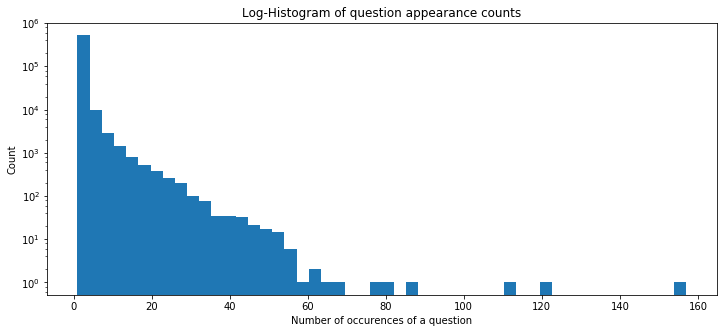

In [22]:
plt.figure(figsize=(12, 5))
plt.hist(qids.value_counts(), bins=50)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of a question')
plt.ylabel('Count')
print()

In [20]:
qs = qids.value_counts() > 100 

In [35]:
qs[qs]

2559     True
30782    True
4044     True
dtype: bool

i'm not sure if x30782 are also counted; #todo

predicting the mean of 1s is suppsed to give descent result, 0.55 on LB! 

In [147]:
from sklearn.metrics import log_loss

p = df_train['is_duplicate'].mean() # Our predicted probability
# p = 16.5
print('Predicted score:', log_loss(df_train['is_duplicate'], np.zeros_like(df_train['is_duplicate']) + p))


# sub = pd.DataFrame({'test_id': df_test['test_id'], 'is_duplicate': p})
# sub.to_csv(path+'subm/default_testset_pvalue_16.5_submission.csv', index=False)
# sub.head()

Predicted score: 0.658527383984


logloss score was 0.658527383984 for 36.5 for training test 1's mean

In [34]:

FileLink('subm/default_testset_pvalue_16.5_submission.csv')

/home/ubuntu/quora/subm/default_testset_pvalue_16.5_submission.csv

This gives a score pf 0.5 on LB

### Sentence Lengths


In [36]:
train_qs = pd.Series(df_train['question1'].tolist() + df_train['question2'].tolist())#.astype(str)
test_qs = pd.Series(df_test['question1'].tolist() + df_test['question2'].tolist())#.astype(str)


In [41]:
def convert_to_unicode(x):
    if type(x) == unicode:
        return x.encode('utf-8')
    else:
#         print ("x was ", x)
        return str(x).encode('utf-8')

In [40]:
train_qs = train_qs.apply(convert_to_unicode)
test_qs = test_qs.apply(convert_to_unicode)

x was  nan
x was  nan
x was  nan
x was  nan
x was  nan
x was  nan


In [42]:
# should remove nans

In [43]:
dist_train = train_qs.apply(len)
dist_test = test_qs.apply(len)



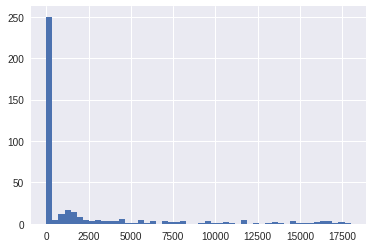

In [56]:
dist_train.value_counts().hist(bins=50, )

In [61]:
print('mean-train {:.2f} std-train {:.2f} mean-test {:.2f} std-test {:.2f} max-train {:.2f} max-test {:.2f}'.format(dist_train.mean(), 
                          dist_train.std(), dist_test.mean(), dist_test.std(), dist_train.max(), dist_test.max()))

mean-train 59.86 std-train 31.99 mean-test 60.11 std-test 31.66 max-train 1169.00 max-test 1176.00


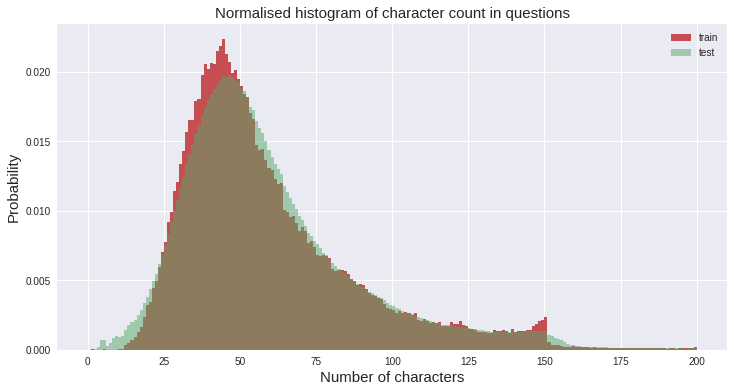

In [51]:
# dist_train = train_qs.apply(len)
# dist_test = test_qs.apply(len)
plt.figure(figsize=(12, 6))
plt.hist(dist_train, bins=200, range=[0, 200], color=pal[2], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], color=pal[1], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)


### Word share feature

In [75]:
import nltk
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [80]:
print(df_train.isnull().sum())
print("\n\n",df_test.isnull().sum())

id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64


 test_id      0
question1    2
question2    4
dtype: int64


In [81]:
df_train = df_train.fillna("?")
df_test = df_test.fillna("?")

In [141]:
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    
#     q1 = row['question1'] if type(row['question1']) == unicode else str(row['question1'])
#     q2 = row['question2'] if type(row['question2']) == unicode else str(row['question2'])
    
    for word in row['question1'].lower().split():
#         if word not in stops:
        q1words[word] = 1
            
    for word in row['question2'].lower().split():
#         if word not in stops:
        q2words[word] = 1
#             print (word)
    
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    
    
    R = (float(len(shared_words_in_q1) + len(shared_words_in_q2)))/(len(q1words) + len(q2words))
    return R

In [142]:
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)

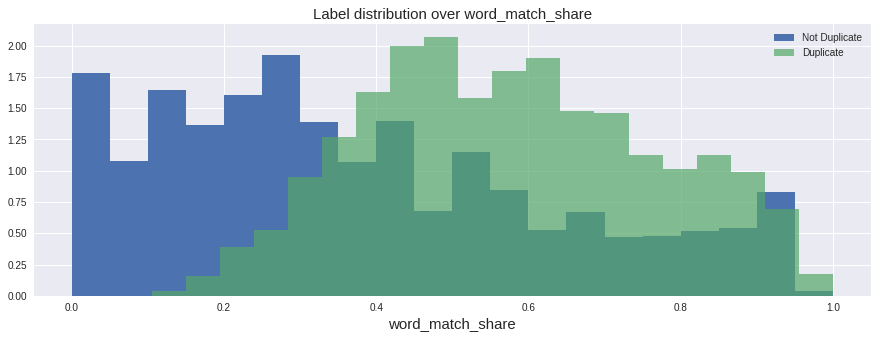

In [143]:
plt.figure(figsize=(15, 5))
train_word_match = df_train.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df_train['is_duplicate'] == 0], bins=20, normed=True, label='Not Duplicate')
plt.hist(train_word_match[df_train['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='Duplicate')
plt.legend()
plt.title('Label distribution over word_match_share', fontsize=15)
plt.xlabel('word_match_share', fontsize=15)

In [148]:
from sklearn.metrics import roc_auc_score
print('Wordmatch AUC:', roc_auc_score(df_train['is_duplicate'], train_word_match))
print('Default probs AUC:', roc_auc_score(df_train['is_duplicate'], [0.658527383984]*len(train_word_match)))

Original AUC: 0.741120504576
Original AUC: 0.5


In [146]:
len(train_word_match),len(df_train)

(404290, 404290)